<a href="https://colab.research.google.com/github/mahmud-sayed-alamin/GNN-Water-mark/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data

In [68]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]
print(f"Dataset: {dataset.name}")
print(f"Number of Nodes: {data.num_nodes}")
print(f"Number of Edges: {data.num_edges}")
print(f"Number of Features: {data.num_node_features}")
print(f"Number of Classes: {dataset.num_classes}")


Dataset: Cora
Number of Nodes: 2708
Number of Edges: 10556
Number of Features: 1433
Number of Classes: 7


In [69]:
torch.manual_seed(42)

In [70]:
class GCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GCN, self).__init__()
        # Define two GCN layers
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.05, training=self.training)

        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [71]:
model = GCN(
    in_channels=1433,
    hidden_channels=32,
    out_channels=7
)

In [72]:
out = model(data.x, data.edge_index)
print(out.shape)

torch.Size([2708, 7])


In [73]:
import torch.nn.functional as F

def compute_loss(output, y, mask):
    loss = F.nll_loss(output[mask], y[mask])
    return loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-2)

In [74]:
def train(data):
    model.train()
    optimizer.zero_grad()
    output = model(data.x, data.edge_index)
    loss = compute_loss(output, data.y, data.train_mask)
    loss.backward()
    optimizer.step()
    return loss.item()

In [75]:
def test(data):
    model.eval()
    output = model(data.x, data.edge_index)
    pred = output.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = pred[mask].eq(data.y[mask]).sum().item()
        acc = correct / mask.sum().item()
        accs.append(acc)
    return accs

In [76]:
for epoch in range(200):
    loss = train(data)
    train_acc, val_acc, test_acc = test(data)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch:03d}, Loss: {loss:.4f}, "
              f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

Epoch: 000, Loss: 1.9558, Train Acc: 0.5429, Val Acc: 0.3200, Test Acc: 0.3470
Epoch: 010, Loss: 1.1722, Train Acc: 0.9643, Val Acc: 0.7600, Test Acc: 0.7910
Epoch: 020, Loss: 0.8760, Train Acc: 0.9714, Val Acc: 0.7660, Test Acc: 0.8160
Epoch: 030, Loss: 0.7322, Train Acc: 0.9786, Val Acc: 0.7780, Test Acc: 0.8190
Epoch: 040, Loss: 0.6941, Train Acc: 0.9786, Val Acc: 0.7860, Test Acc: 0.8170
Epoch: 050, Loss: 0.7221, Train Acc: 0.9786, Val Acc: 0.7800, Test Acc: 0.8140
Epoch: 060, Loss: 0.7481, Train Acc: 0.9714, Val Acc: 0.7840, Test Acc: 0.8090
Epoch: 070, Loss: 0.7325, Train Acc: 0.9786, Val Acc: 0.7820, Test Acc: 0.8100
Epoch: 080, Loss: 0.7338, Train Acc: 0.9786, Val Acc: 0.7820, Test Acc: 0.8080
Epoch: 090, Loss: 0.7316, Train Acc: 0.9714, Val Acc: 0.7860, Test Acc: 0.8160
Epoch: 100, Loss: 0.7278, Train Acc: 0.9857, Val Acc: 0.7800, Test Acc: 0.8140
Epoch: 110, Loss: 0.7344, Train Acc: 0.9786, Val Acc: 0.7820, Test Acc: 0.8110
Epoch: 120, Loss: 0.7241, Train Acc: 0.9714, Val Acc

In [77]:
def evaluate(data):
    model.eval()  # Set the model to evaluation mode

    # Forward pass to get predictions
    with torch.no_grad():  # No gradients needed during evaluation
        output = model(data.x, data.edge_index)

    # Get predicted class for each node
    predictions = output.argmax(dim=1)  # Pick the class with the highest probability

    # Calculate accuracy for train, validation, and test sets
    accuracies = {}
    for mask_name, mask in [('Train', data.train_mask),
                            ('Validation', data.val_mask),
                            ('Test', data.test_mask)]:
        correct = predictions[mask].eq(data.y[mask]).sum().item()  # Correct predictions
        total = mask.sum().item()  # Total nodes in the mask
        accuracy = correct / total
        accuracies[mask_name] = accuracy

    return accuracies

In [78]:
# Initialize lists to track accuracy and loss
train_acc_list = []
val_acc_list = []
loss_list = []

for epoch in range(200):  # Train for 200 epochs
    # Train the model
    loss = train(data)
    loss_list.append(loss)  # Store the loss

    # Evaluate the model on train and validation sets
    accuracies = evaluate(data)
    train_acc_list.append(accuracies['Train'])  # Store train accuracy
    val_acc_list.append(accuracies['Validation'])  # Store validation accuracy

    # Print progress every 10 epochs
    if epoch % 10 == 0:
        print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, "
              f"Train Acc: {accuracies['Train']:.4f}, "
              f"Val Acc: {accuracies['Validation']:.4f}, "
              f"Test Acc: {accuracies['Test']:.4f}")



Epoch 000, Loss: 0.7225, Train Acc: 0.9786, Val Acc: 0.7840, Test Acc: 0.8120
Epoch 010, Loss: 0.7239, Train Acc: 0.9714, Val Acc: 0.7800, Test Acc: 0.8110
Epoch 020, Loss: 0.7175, Train Acc: 0.9786, Val Acc: 0.7840, Test Acc: 0.8090
Epoch 030, Loss: 0.7248, Train Acc: 0.9786, Val Acc: 0.7800, Test Acc: 0.8080
Epoch 040, Loss: 0.7262, Train Acc: 0.9786, Val Acc: 0.7820, Test Acc: 0.8100
Epoch 050, Loss: 0.7210, Train Acc: 0.9786, Val Acc: 0.7820, Test Acc: 0.8120
Epoch 060, Loss: 0.7233, Train Acc: 0.9786, Val Acc: 0.7840, Test Acc: 0.8120
Epoch 070, Loss: 0.7254, Train Acc: 0.9714, Val Acc: 0.7860, Test Acc: 0.8140
Epoch 080, Loss: 0.7227, Train Acc: 0.9857, Val Acc: 0.7840, Test Acc: 0.8110
Epoch 090, Loss: 0.7350, Train Acc: 0.9786, Val Acc: 0.7820, Test Acc: 0.8160
Epoch 100, Loss: 0.7212, Train Acc: 0.9714, Val Acc: 0.7840, Test Acc: 0.8120
Epoch 110, Loss: 0.7295, Train Acc: 0.9857, Val Acc: 0.7860, Test Acc: 0.8110
Epoch 120, Loss: 0.7311, Train Acc: 0.9857, Val Acc: 0.7780, Tes

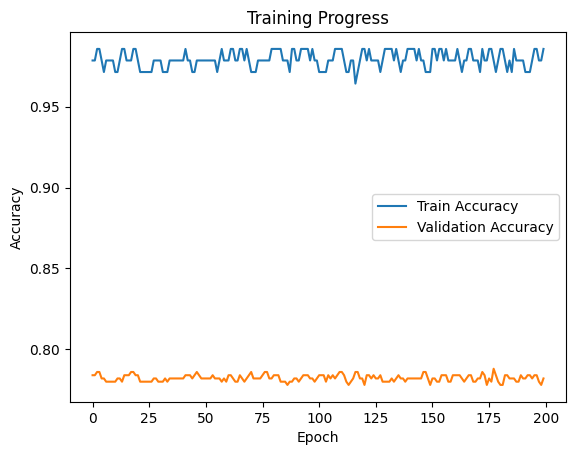

In [79]:
import matplotlib.pyplot as plt

# Suppose you logged the losses and accuracies during training
epochs = range(len(train_acc_list))  # List of epoch numbers
plt.plot(epochs, train_acc_list, label="Train Accuracy")
plt.plot(epochs, val_acc_list, label="Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Progress")
plt.show()


In [80]:
def generate_trigger_graph(data, model, num_trigger_nodes=10, target_label=0):
    # Get model predictions for all nodes
    model.eval()
    with torch.no_grad():
        output = model(data.x, data.edge_index)
        predictions = output.argmax(dim=1)

    # Select nodes with the highest probability for the target label
    target_nodes = torch.where(predictions == target_label)[0][:num_trigger_nodes]

    # Generate trigger nodes and connect them to the selected nodes
    trigger_features = data.x[target_nodes].clone()  # Copy features of target nodes
    trigger_adj = torch.eye(num_trigger_nodes)  # Create self-loops for trigger nodes

    # Attach trigger nodes to the clean graph
    new_features = torch.cat([data.x, trigger_features], dim=0)
    new_adj = torch.block_diag(data.edge_index, trigger_adj)

    return new_features, new_adj

In [81]:
def train_with_watermark(data, trigger_graph, target_label):
    model.train()
    optimizer.zero_grad()

    # Combine clean graph with trigger graph
    x_combined = torch.cat([data.x, trigger_graph['features']], dim=0)
    edge_index_combined = torch.cat([data.edge_index, trigger_graph['edges']], dim=1)

    # Forward pass
    output = model(x_combined, edge_index_combined)

    # Compute classification loss
    loss = F.nll_loss(output[data.train_mask], data.y[data.train_mask])

    # Add watermarking loss (if applicable)
    trigger_loss = F.nll_loss(output[trigger_graph['nodes']], target_label)
    total_loss = loss + trigger_loss

    # Backward pass
    total_loss.backward()
    optimizer.step()

    return total_loss.item()



In [82]:
def verify_ownership(model, trigger_graph, target_label):
    model.eval()
    with torch.no_grad():
        output = model(trigger_graph['features'], trigger_graph['edges'])

    # Measure accuracy of trigger set
    predictions = output.argmax(dim=1)
    trigger_accuracy = (predictions == target_label).sum().item() / len(trigger_graph['nodes'])

    return trigger_accuracy

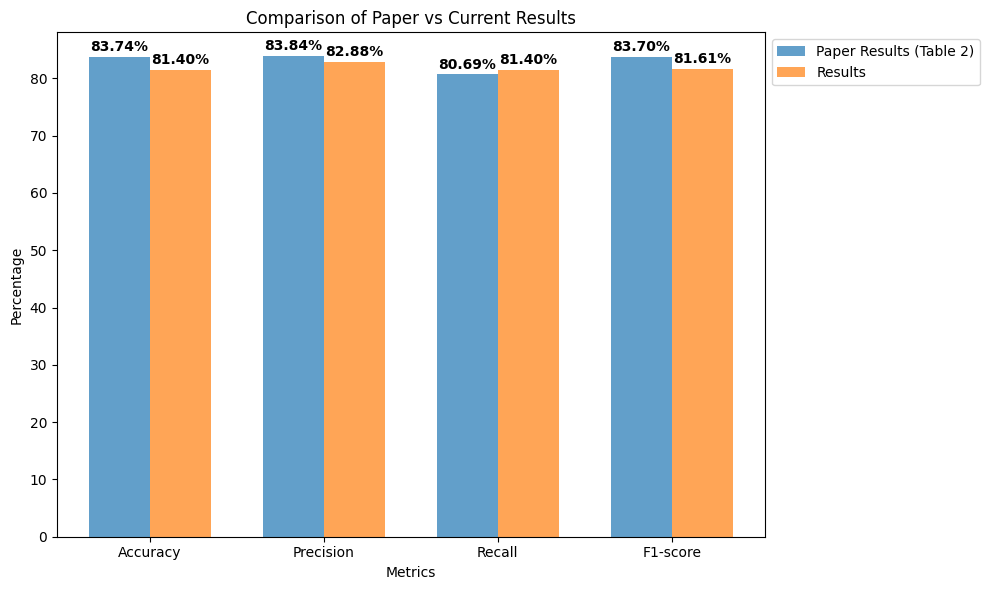

In [83]:
import matplotlib.pyplot as plt
import numpy as np

# Paper results from Table 2 (Cora, GCN)
paper_results = [83.74, 83.84, 80.69, 83.70]  # Accuracy, Precision, Recall, F1-score

accuracy = fidelity_results['Test'] * 100
precision = precision_score(data.y[data.test_mask].cpu(),
                                     model(data.x, data.edge_index)[data.test_mask].argmax(dim=1).cpu(),
                                     average="weighted") * 100
_recall = recall_score(data.y[data.test_mask].cpu(),
                               model(data.x, data.edge_index)[data.test_mask].argmax(dim=1).cpu(),
                               average="weighted") * 100
_f1 = f1_score(data.y[data.test_mask].cpu(),
                        model(data.x, data.edge_index)[data.test_mask].argmax(dim=1).cpu(),
                        average="weighted") * 100

_results = [_accuracy, _precision, _recall, _f1]

metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

bar_width = 0.35
index = np.arange(len(metrics))

plt.figure(figsize=(10, 6))

bars1 = plt.bar(index, paper_results, bar_width, label="Paper Results (Table 2)", alpha=0.7)
bars2 = plt.bar(index + bar_width, _results, bar_width, label="Results", alpha=0.7)

for bar in bars1:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f"{bar.get_height():.2f}%",
             ha="center", va="bottom", fontsize=10, color="black", fontweight="bold")

for bar in bars2:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() + 0.5, f"{bar.get_height():.2f}%",
             ha="center", va="bottom", fontsize=10, color="black", fontweight="bold")

plt.xlabel("Metrics")
plt.ylabel("Percentage")
plt.title("Comparison of Paper vs Current Results")
plt.xticks(index + bar_width / 2, metrics)

plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.tight_layout()